In [297]:
# from netCDF4 import Dataset
import os, glob
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
# from datetime import datetime
import importlib
import wrftools as wrf
importlib.reload(wrf)

<module 'wrftools' from '/net/wrfstore6/disk1/nsparks/itc/python/wrftools.py'>

In [298]:
def create_delta_df(df):
    def antidiff_df(df): 
    # calc rolling 2 row mean, builds upon pd rolling for numerical list elements 
        dfm=df.rolling(2).mean()
        missingkeys=(np.setdiff1d(df.keys(),dfm.keys())) # missing because rolling ignores arrays
#         print(missingkeys)
        for k in missingkeys:
#             print(k)
            dfk=df[k]
            dfkm=[np.nan]
            for i in range(len(dfk)-1):
                ar=np.array(np.mean((dfk[i],dfk[i+1]),0))
                dfkm.append(ar)
            dfm[k]=dfkm
        return(dfm)

    dfd=df.diff()
    dfm=antidiff_df(df)

    dfm['dPbardt']=dfd['Pbar']/(60*60)
    Vr=[]
    dPrdr=[]
    dr=dfm['r'][1][1]-dfm['r'][1][0]
    for i in range(len(dfm)):
        Vr.append((100*dfm['dPbardt'][i])*(dfm['r'][i]*1000)/(2*dfm['Pr'][i]*100))
        dPrdr.append(100*np.gradient(dfm['Pr'][i])/(dr*1000))
    dfm['Vrcol']=Vr
    dfm['dPrdr']=dPrdr
    return(dfm)

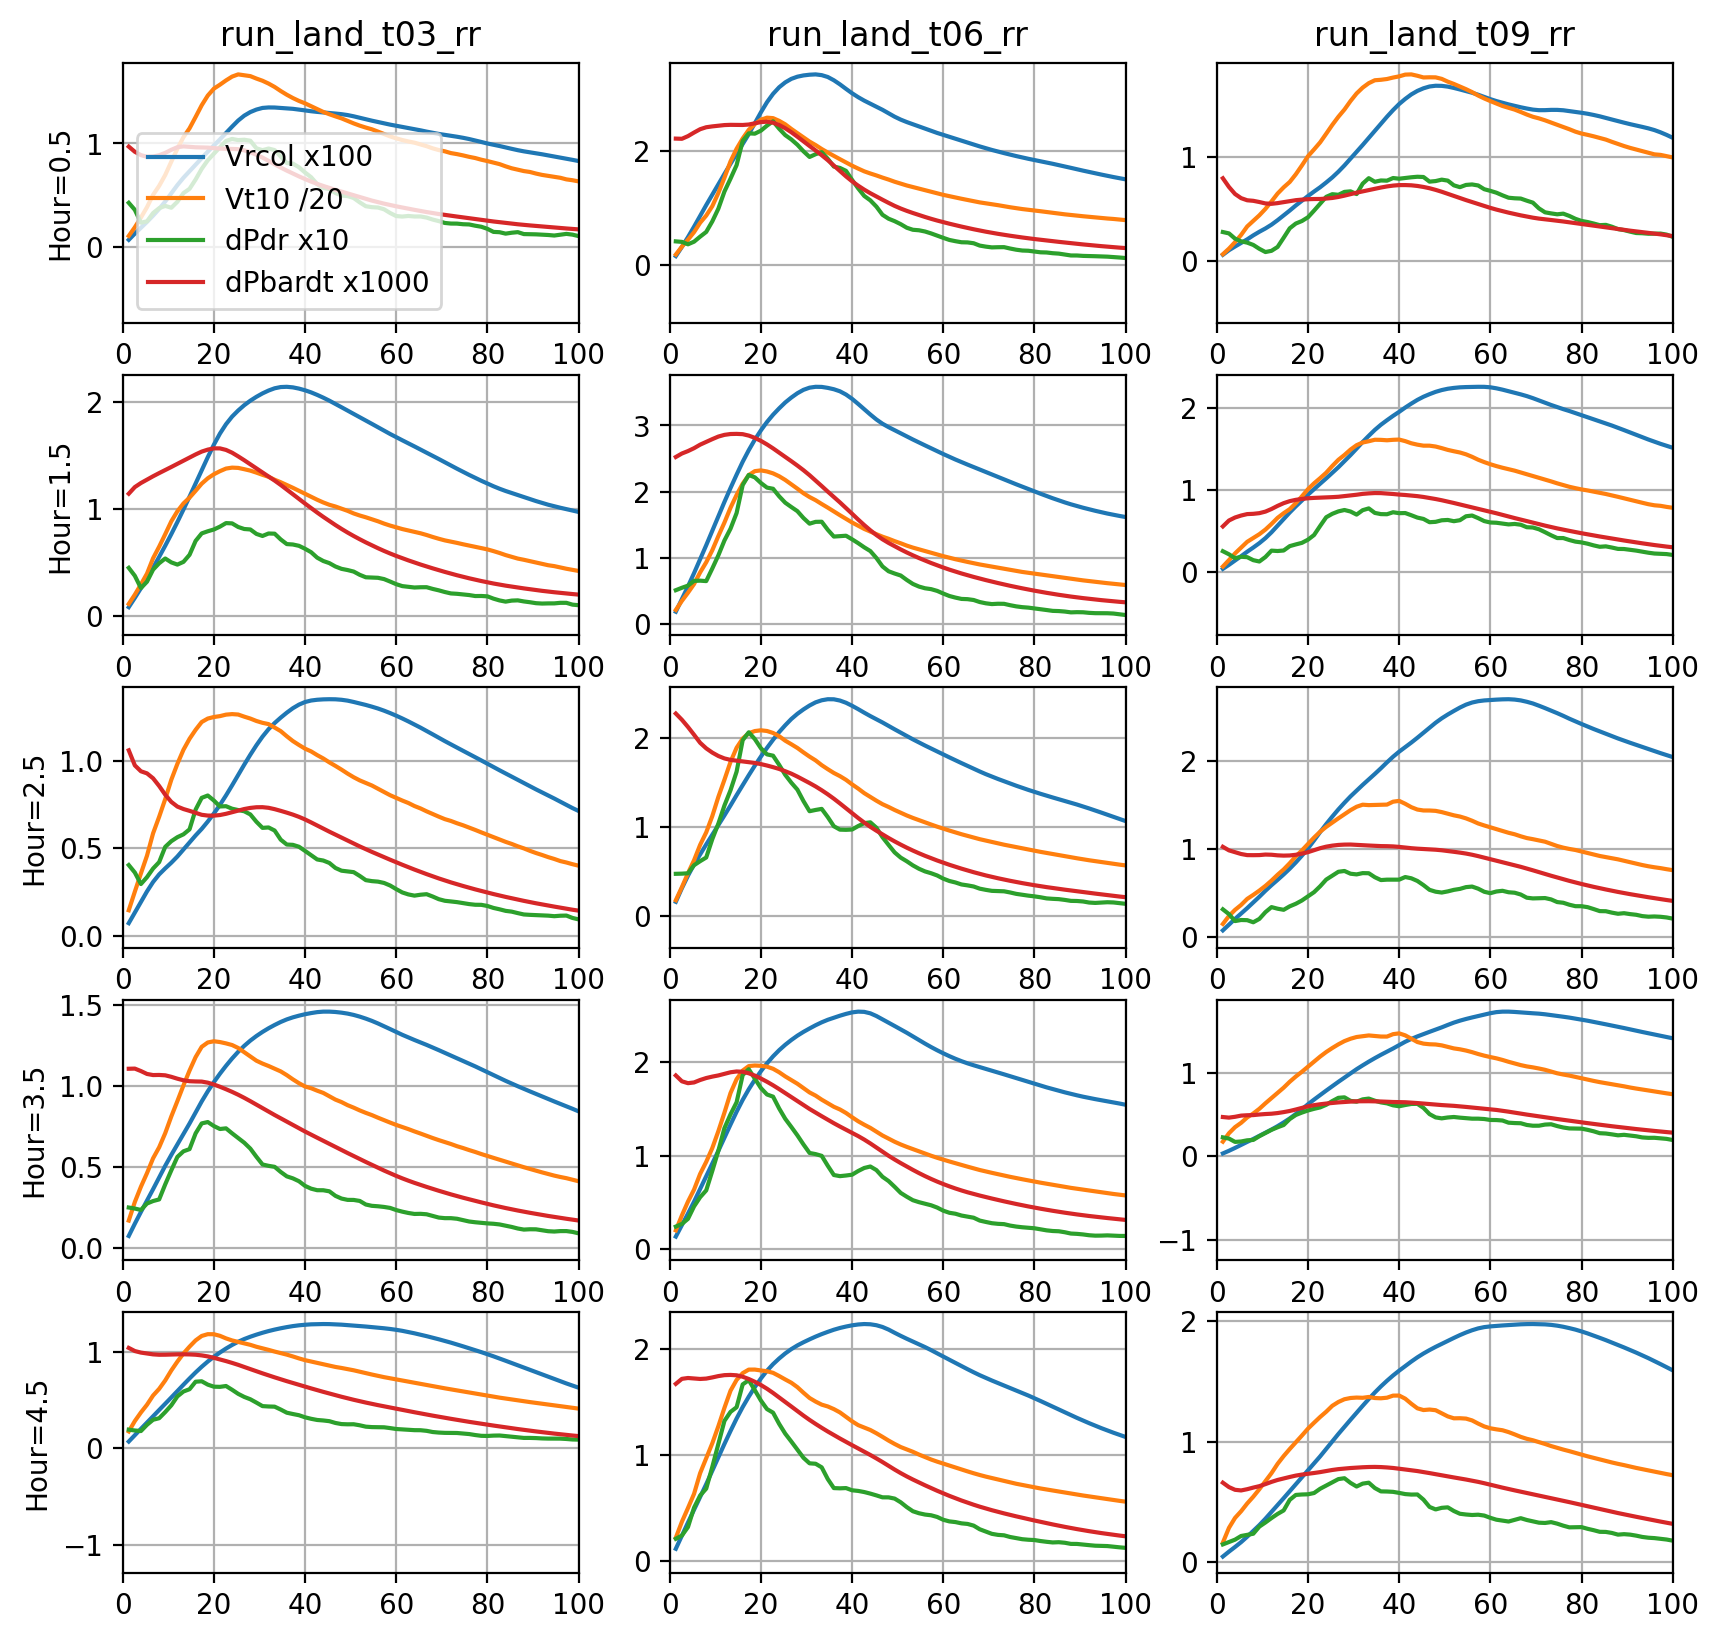

In [285]:
fig,axs=plt.subplots(5,3,dpi=200,figsize=(10,10))
runs=['run_land_t03_rr','run_land_t06_rr','run_land_t09_rr']
for j in range(3):
    run=runs[j]
    dfname='rundf/df_' + run + '.pkl'
    df=pd.read_pickle(dfname)
    dfd=create_delta_df(df)
    for i in range(5):
        
        row=i+1

        r=dfd['r'][row]
        dPrdr=dfd['dPrdr'][row]
        Vrcol=dfd['Vrcol'][row]
        Vt10=dfd['Vt10'][row]
        dPbardt=dfd['dPbardt'][row]

        ax=axs[i,j]
        ax.plot(r,Vrcol*100)
        ax.plot(r,Vt10/20)
        ax.plot(r,dPrdr*10)
        ax.plot(r,dPbardt*1000)
        if i==0:
            ax.set_title(run)
        if j==0:
            ax.set_ylabel('Hour='+str(row-0.5))

        ax.grid(True)
        ax.set_xlim((0,100))
        
axs[0,0].legend(('Vrcol x100','Vt10 /20','dPdr x10','dPbardt x1000'))

In [300]:
tlfs=[0,2,3,4,5,6,7,8,9,10,11,12,13]
runs=['run_CTRL_rr'] + ['run_land_dry_t'+ '{:02d}'.format(x+1) + '' for x in lfts[1:]]
dfn = pd.DataFrame(columns=['tlf','t','V10max','rV10max','Pmin','P','r','Vt10','Vrcol','dPdr'])

for n,run in enumerate(runs[1:]):
    print(run)
    dfname='rundf/df_' + run + '.pkl'
    df=pd.read_pickle(dfname)
    dfd=create_delta_df(df)

    tlf=tlfs[n+1]
    for i,row in dfd[1:].iterrows():
    #     print(row['r'])
        t=row['t']
        rs=row['r']
        V10max=row['V10max']
        rV10max=row['rV10max']
        Pmin=row['pmin']
    #     print('i=' + str(i))
        for j,r in enumerate(rs[rs<100]):
    #         print(j)
            newrow = pd.Series({
                'tlf':tlf,
                't':t,'V10max':V10max,'rV10max':rV10max,'Pmin':Pmin,\
                'P':row['Pr'][j],'r':r,'Vt10':row['Vt10'][j],'Vrcol':row['Vrcol'][j],'dPdr':row['dPrdr'][j]})
            dfn=dfn.append(newrow,ignore_index=True)

print(dfn)
dfn.to_pickle('rundf/df_lin_dry_rr',protocol=4)

run_land_dry_t03
run_land_dry_t04
run_land_dry_t05
run_land_dry_t06
run_land_dry_t07
run_land_dry_t08
run_land_dry_t09
run_land_dry_t10
run_land_dry_t11
run_land_dry_t12
run_land_dry_t13
        tlf          t     V10max    rV10max         Pmin            P  \
0       2.0   2.020833  35.409608  24.666665   964.620605   964.620605   
1       2.0   2.020833  35.409608  24.666665   964.620605   965.217407   
2       2.0   2.020833  35.409608  24.666665   964.620605   965.711792   
3       2.0   2.020833  35.409608  24.666665   964.620605   966.092163   
4       2.0   2.020833  35.409608  24.666665   964.620605   966.625427   
...     ...        ...        ...        ...          ...          ...   
19795  12.0  12.979167   5.412356  22.666665  1001.624146  1003.021240   
19796  12.0  12.979167   5.412356  22.666665  1001.624146  1003.028320   
19797  12.0  12.979167   5.412356  22.666665  1001.624146  1003.060425   
19798  12.0  12.979167   5.412356  22.666665  1001.624146  1003.070435   